In [1]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt, prettytable as pt
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(""))))

# Dados da Simulação

Text(0.5, 1.0, 'Caso: caso_1_.csv | Medição: Imed_B2')

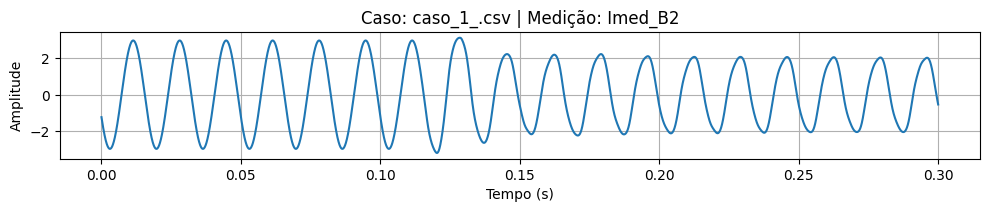

In [2]:
from functions.ProcessamentoCSV import Dunno

casoSimulado = 'caso_1_.csv'
ponto_de_medicao = 'Imed_B2'

all_signals = Dunno.data_selection_mod_Alailton(
    file_path = casoSimulado,
    meas = ponto_de_medicao
)

signal = all_signals[:, 0]
t_simulation = 0.3
fs = 30720
nSamples = int(t_simulation * fs)
t = np.linspace(0, t_simulation, signal.shape[0])
plt.figure(figsize=(10, 2))
plt.plot(t, signal)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.title(f'Caso: {casoSimulado} | Medição: {ponto_de_medicao}')

# Rotina Transformada de Fourier

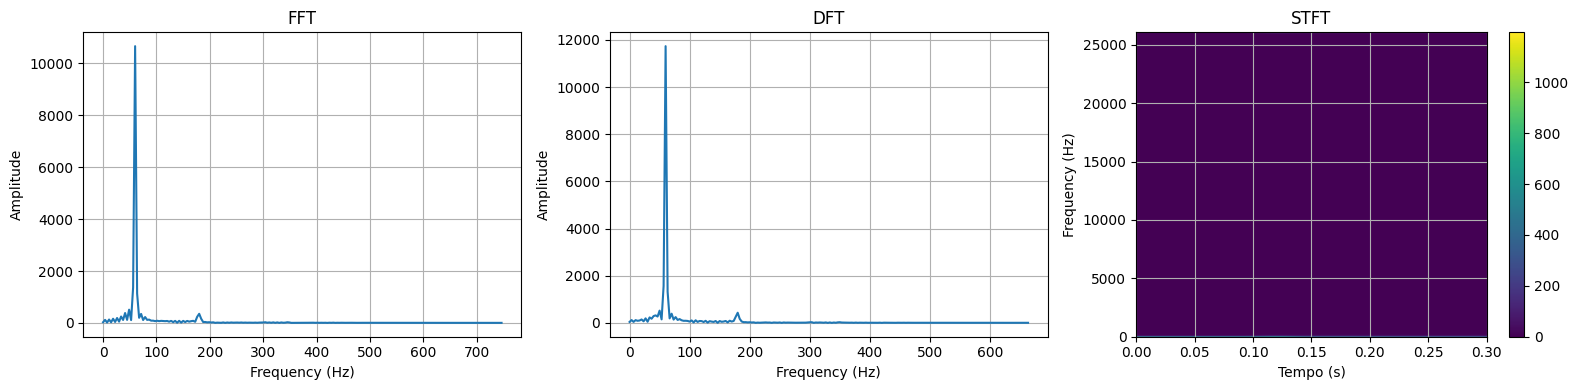

In [9]:
from functions.TF import FFT_function, DFT_function, STFT_function

signal_fft = FFT_function.FFT( # Realiza o calculo da FFT
    x = signal[0:2**13]
)
signal_dft = DFT_function.discrete_fourier_transform.DFT( # Realiza o calculo da DFT
    x = signal
)
frame_size = 0.05
nFrames = int(t_simulation / frame_size)
nSamplesPerFrame = int(frame_size * fs)
hop = int((nSamples - nSamplesPerFrame) / (nFrames - 1))/fs
signal_stft = STFT_function.short_time_fourier_transform.STFT( # Realiza o calculo da STFT
    x = signal,
    fs = fs,
    frame_size = 0.05,
    hop = 0.001
)

freq_fft = np.fft.fftfreq(signal_fft.shape[0], 1/fs)
freq_dft = np.fft.fftfreq(signal_dft.shape[0], 1/fs)
freq_stft = np.fft.fftshift(np.fft.fftfreq(nSamplesPerFrame, d=1/fs))

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(freq_fft[0:200], np.abs(signal_fft[0:200]), label='FFT')
plt.grid(True)
plt.title('FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(1,3,2)
plt.plot(freq_dft[0:200], np.abs(signal_dft[0:200]), label='DFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('DFT')

plt.subplot(1,3,3)
plt.imshow(np.abs(signal_stft.T), aspect='auto', origin='lower', extent=[t.min(), t.max(), 0, freq_stft.max()*1.7])
plt.xlabel('Tempo (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.grid(True)
plt.title('STFT')
plt.tight_layout()
plt.show()

# Rotina Transformada Wavelet

Text(0.5, 1.0, 'cD')

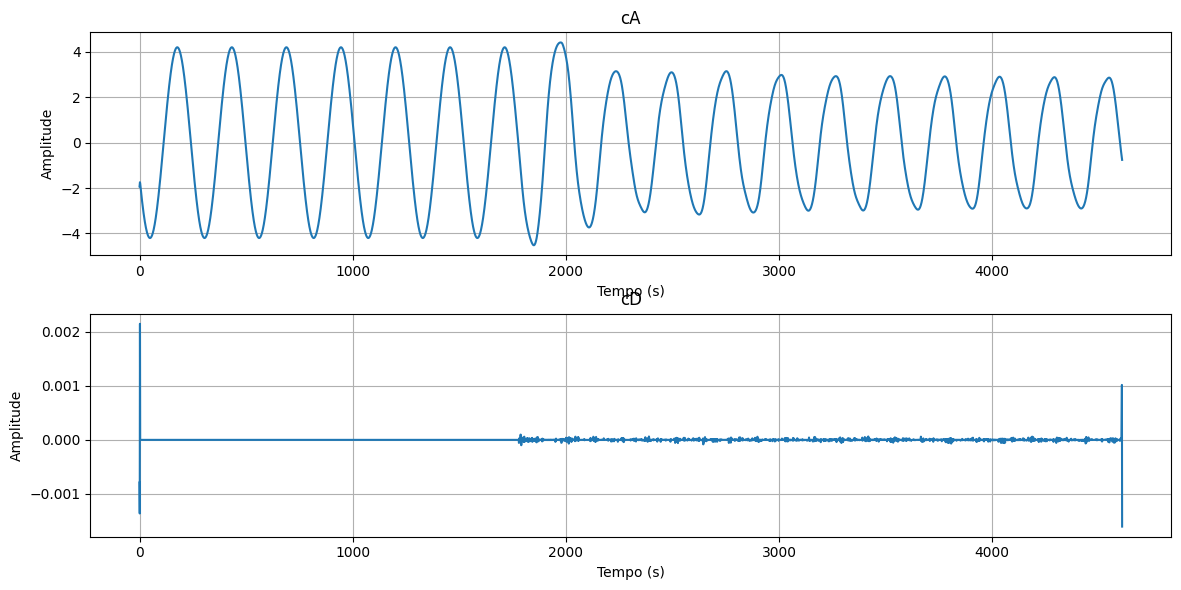

In [26]:
from functions.TW import DTW

signal_dwt = DTW.DWT.transform(
    data = signal,
    wavelet = 'db4',
)
signal_dwt = DTW.DWT.transform(
    data = signal,
    dec_low = [0.707106, 0.7071067],
    dec_hi = [-0.707106, 0.7071067],
)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal_dwt[0], label='cA')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.title("cA")

plt.subplot(2,1,2)
plot = plt.plot(signal_dwt[1], label='cD')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.title("cD")

# Rotina Transformada de Stockwell

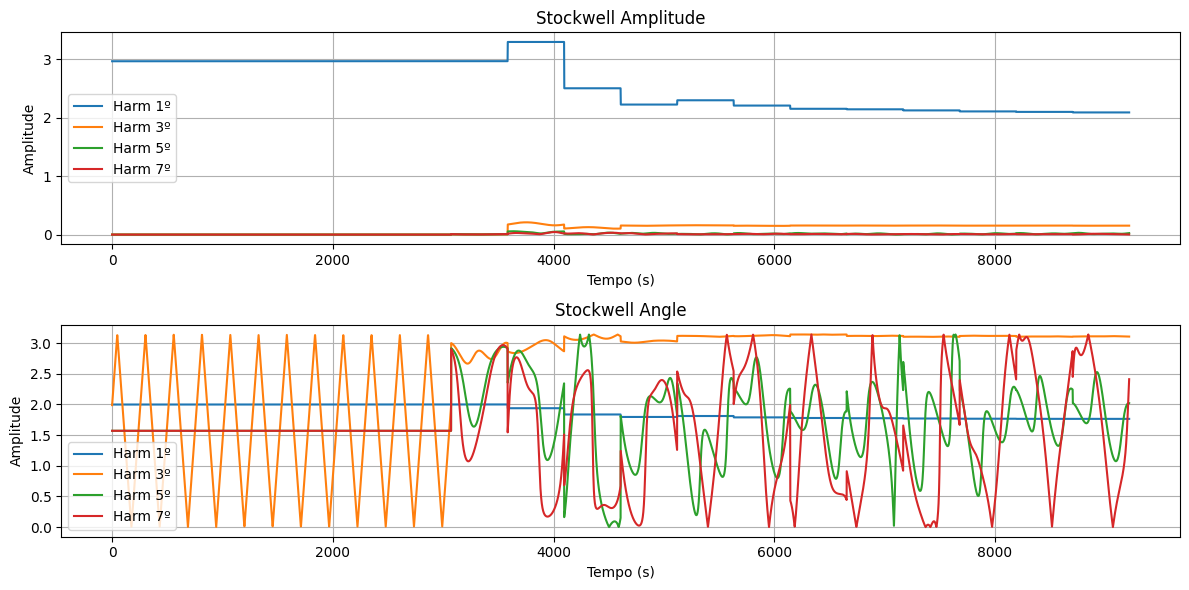

In [11]:
from functions.TS import ST

stClass = ST.Stockwell()
signal_ST = stClass.calcula_TS_do_sinal(
    sinal = signal,
    tamanho_da_janela = int(fs/60),
    k = 1
)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
for i in range(1, 9, 2):
    plt.plot(signal_ST[0][i, :], label=f'Harm {i}º')
plt.title('Stockwell Amplitude')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
for i in range(1, 9, 2):
    plt.plot(signal_ST[1][i, :], label=f'Harm {i}º')
plt.title('Stockwell Angle')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.legend()

# Rotina Transformada Trifásica

Text(0.5, 1.0, 'Transformada de Park')

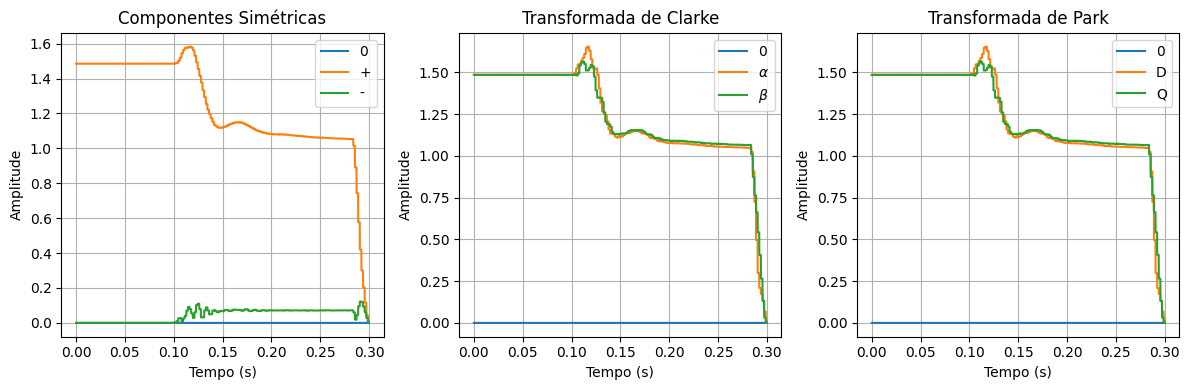

In [20]:
from functions.TT import clarke, park, componentes_simetricas
from numpy.fft import fft
from functions.TT.clarke import clarke_ABCtoAB0
from functions.TT.park import park_ABCtoDQ
from functions.TT.componentes_simetricas import comp_sim_ABCto012


window = int(fs/60)
window_step = int(0.1/60*fs)
signal_compSym = np.zeros((nSamples, 3), dtype=complex)
signal_clarke = np.zeros((nSamples, 3), dtype=complex)
signal_park = np.zeros((nSamples, 3), dtype=complex)

i = 0
while i < nSamples:
    Va = fft(all_signals[i:i+window, 0])[1]/window
    Vb = fft(all_signals[i:i+window, 1])[1]/window
    Vc = fft(all_signals[i:i+window, 2])[1]/window
    signal_compSym[i:i+window_step] = comp_sim_ABCto012(Va, Vb, Vc)
    signal_clarke[i:i+window_step] = clarke_ABCtoAB0(Va, Vb, Vc)
    signal_park[i:i+window_step] = park_ABCtoDQ(Va, Vb, Vc, 0)
    i += window_step

plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.plot(t, np.abs(signal_compSym[:,0]), label='0')
plt.plot(t, np.abs(signal_compSym[:,1]), label='+')
plt.plot(t, np.abs(signal_compSym[:,2]), label='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.title('Componentes Simétricas')

plt.subplot(1,3,2)
plt.plot(t, np.abs(signal_clarke[:,0]), label='0')
plt.plot(t, np.abs(signal_clarke[:,1]), label=r'$\alpha$')
plt.plot(t, np.abs(signal_clarke[:,2]), label=r'$\beta$')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.title('Transformada de Clarke')

plt.subplot(1,3,3)
plot = plt.plot(t, np.abs(signal_park[:,0]), label='0')
plot = plt.plot(t, np.abs(signal_park[:,1]), label='D')
plot = plt.plot(t, np.abs(signal_park[:,2]), label='Q')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.title('Transformada de Park')

## Variational Mode Decomposition (VMD) algorithm.

c:\Users\alail\OneDrive\Documentos\Github\preprocessing\functions\VMD\VMD.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  u[:, k] = np.fft.ifft(np.fft.fft(X) / (alpha_k[:, k] + 1j * omega[:, k]))


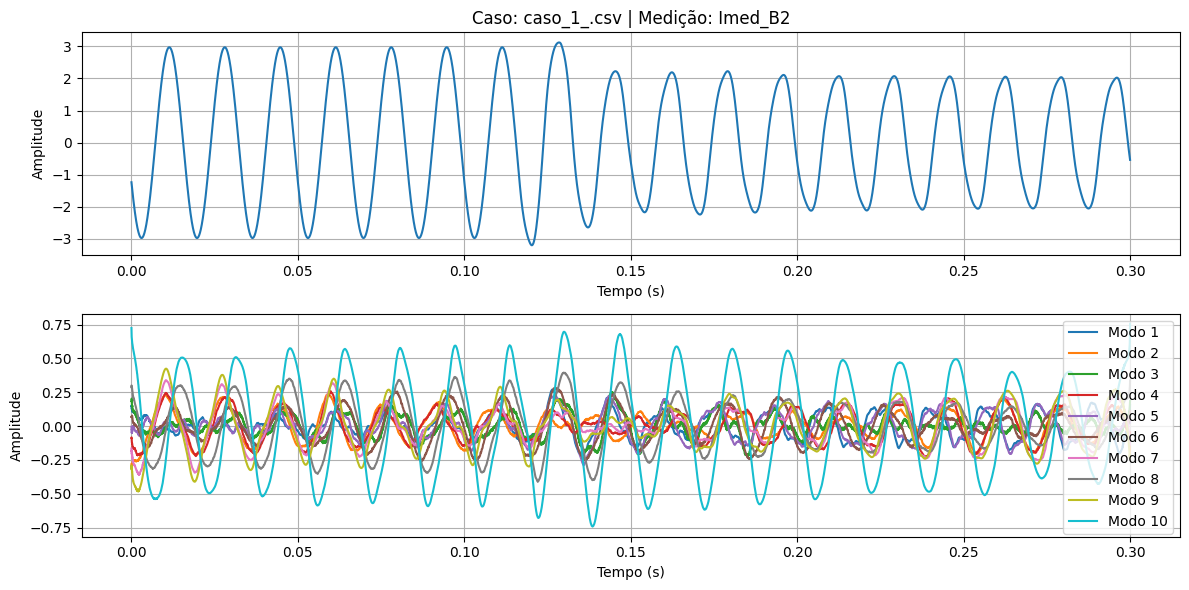

In [23]:
from functions.VMD import VMD

signal_vmd = VMD.vmd(
    X = signal,
    alpha = 200,
    tau = 0.1,
    K = 10,
    tol = 1e-7,
    max_iter = 500
)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.grid(True)
plt.title(f'Caso: {casoSimulado} | Medição: {ponto_de_medicao}')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.tight_layout()


for i, modes in enumerate(signal_vmd.T):
    plt.subplot(2, 1, 2)
    plt.plot(t, modes, label=f'Modo {i+1}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
plt.legend()
plt.tight_layout()

# EMD

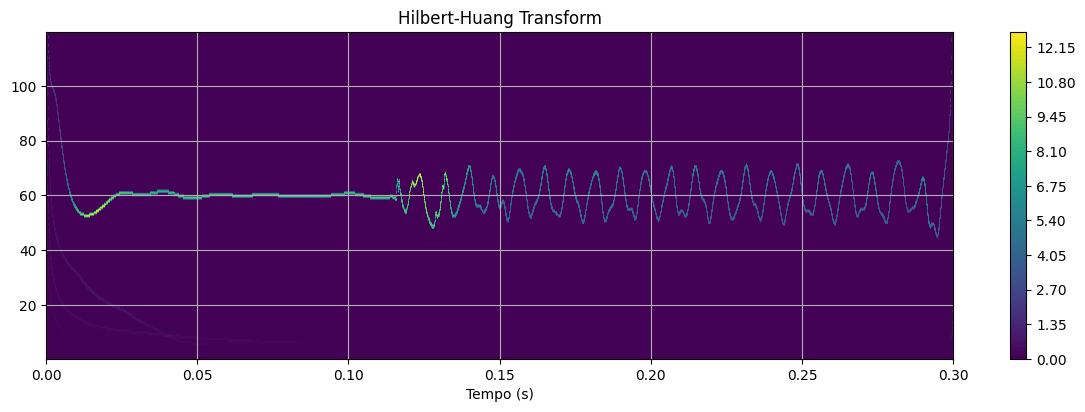

In [24]:
import emd

imf = emd.sift.sift(signal)
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
freq_range = (0, 120, 200)
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)


plt.figure(figsize=(12, 4))
plt.contourf(t, f, hht, 100)
plt.colorbar()
plt.xlabel('Tempo (s)')
plt.grid(True)
plt.tight_layout()
plot = plt.title('Hilbert-Huang Transform')